In [5]:
# ============================================================
# Stacking LR + MLP con análisis de la zona gris
# ============================================================
import os, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    f1_score, precision_score, recall_score
)
from sklearn.isotonic import IsotonicRegression

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks, metrics

# ---------------- Config ----------------
SEED = 42
N_SPLITS = 5
USE_ISOTONIC = True
Q_POS, Q_NEG = 0.10, 0.03  # cuantiles para zona gris
ALPHA = 3.0
BONUS_POS = 1.0
QUADRATIC = True
EPOCHS = 200
BATCH = 64

DATA_PATH = r"C:\Users\axime\Downloads\nueva_data\modelado\MODELO_FINAL\modelo_final.ipynb\df_priority6_with_response_index.csv"
OUT_DIR = os.path.dirname(DATA_PATH)

np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

# ---------------- Data prep ----------------
df = pd.read_csv(DATA_PATH)
X_df = df.drop(columns=[c for c in ["Response","ID"] if c in df.columns])
X_df = pd.get_dummies(X_df, drop_first=False)
y = df["Response"].astype(int).values

imp = SimpleImputer(strategy="median")
scaler = StandardScaler()
X = imp.fit_transform(X_df)
X = scaler.fit_transform(X).astype(np.float32)
INPUT_DIM = X.shape[1]

print(f"[INFO] X shape={X_df.shape}, Pos={y.sum()}, Neg={len(y)-y.sum()} | PosRate={y.mean():.3f}")

def best_f1_threshold(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1s = 2*(prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    return float(thr[np.nanargmax(f1s)])

# ---------------- 1) OOF LR ----------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
oof_lr = np.zeros_like(y, dtype=np.float32)

for fold, (i_tr, i_va) in enumerate(skf.split(X, y), 1):
    lr = LogisticRegression(solver="liblinear", class_weight="balanced",
                            penalty="l2", C=1.0, max_iter=1000, random_state=SEED+fold)
    lr.fit(X[i_tr], y[i_tr])
    oof_lr[i_va] = lr.predict_proba(X[i_va])[:,1]

roc_lr = roc_auc_score(y, oof_lr)
pr_lr  = average_precision_score(y, oof_lr)
thr_lr = best_f1_threshold(y, oof_lr)
print(f"\n=== LR (OOF) ===\nROC-AUC={roc_lr:.4f} | AUCPR={pr_lr:.4f} | BestThr={thr_lr:.4f}")

# ---------------- 2) Zona gris asimétrica ----------------
yhat_lr  = (oof_lr >= thr_lr).astype(int)
FP_mask  = (yhat_lr == 1) & (y == 0)
FN_mask  = (yhat_lr == 0) & (y == 1)
d_poserr = np.abs(oof_lr[FP_mask] - thr_lr)
d_negerr = np.abs(oof_lr[FN_mask] - thr_lr)
if d_poserr.size == 0: d_poserr = np.abs(oof_lr[oof_lr>=thr_lr] - thr_lr)
if d_negerr.size == 0: d_negerr = np.abs(oof_lr[oof_lr< thr_lr] - thr_lr)
w_pos = float(np.quantile(d_poserr, Q_POS)) if d_poserr.size else 0.0
w_neg = float(np.quantile(d_negerr, Q_NEG)) if d_negerr.size else 0.0
print(f"Zona gris asimétrica: w_neg={w_neg:.4f} | w_pos={w_pos:.4f} -> rango: [{thr_lr-w_neg:.3f}, {thr_lr+w_pos:.3f}]")

# ---------------- 3) OOF MLP (gray-boosted) ----------------
def build_mlp(input_dim, hidden=(256,128,64), dropout=0.3, l2=1e-4, lr=1e-3):
    m = models.Sequential()
    m.add(layers.Input(shape=(input_dim,)))
    for h in hidden:
        m.add(layers.Dense(h, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2)))
        m.add(layers.BatchNormalization()); m.add(layers.Activation("relu")); m.add(layers.Dropout(dropout))
    m.add(layers.Dense(1, activation="sigmoid"))
    m.compile(optimizer=optimizers.Adam(learning_rate=lr),
              loss="binary_crossentropy",
              metrics=[metrics.AUC(curve="PR", name="auprc"), metrics.AUC(curve="ROC", name="roc_auc")])
    return m

oof_mlp = np.zeros_like(y, dtype=np.float32)

for fold, (i_tr, i_va) in enumerate(skf.split(X, y), 1):
    X_tr, y_tr = X[i_tr], y[i_tr]
    X_va, y_va = X[i_va], y[i_va]
    # LR para pesos
    lr_fold = LogisticRegression(solver="liblinear", class_weight="balanced",
                                 penalty="l2", C=1.0, max_iter=1000, random_state=SEED+100+fold)
    lr_fold.fit(X_tr, y_tr)
    p_lr_tr = lr_fold.predict_proba(X_tr)[:,1]
    margin = np.abs(p_lr_tr - thr_lr)
    local_w = np.where(p_lr_tr < thr_lr, w_neg, w_pos)
    g = np.zeros_like(margin)
    mask_v = local_w > 0
    base = 1.0 - (margin[mask_v] / (local_w[mask_v] + 1e-6))
    g[mask_v] = np.clip(base, 0.0, 1.0)
    if QUADRATIC: g[mask_v] = g[mask_v]**2
    sample_w = 1.0 + ALPHA*g
    sample_w += BONUS_POS * ((g > 0) & (y_tr == 1))
    # Entrena MLP
    mlp = build_mlp(INPUT_DIM)
    _ = mlp.predict(np.zeros((1, INPUT_DIM), dtype=np.float32), batch_size=1, verbose=0)
    cbs = [callbacks.EarlyStopping(monitor="val_auprc", mode="max", patience=20, restore_best_weights=True, verbose=0)]
    mlp.fit(X_tr, y_tr, validation_data=(X_va,y_va), sample_weight=sample_w,
            epochs=EPOCHS, batch_size=BATCH, callbacks=cbs, verbose=0)
    oof_mlp[i_va] = mlp.predict(X_va, batch_size=1024, verbose=0).ravel()

print(f"\n=== MLP (OOF gray-boosted) ===\nROC-AUC={roc_auc_score(y,oof_mlp):.4f} | AUCPR={average_precision_score(y,oof_mlp):.4f}")

# ---------------- 4) STACKING (meta-LR + isotónica) ----------------
mask_gray_all = ((oof_lr >= (thr_lr - w_neg)) & (oof_lr <= (thr_lr + w_pos)))
Z = np.column_stack([oof_lr, oof_mlp, np.abs(oof_lr-thr_lr), oof_mlp-oof_lr, mask_gray_all.astype(int)])

oof_stack = np.zeros_like(y, dtype=np.float32)
for fold, (i_tr, i_va) in enumerate(skf.split(Z,y),1):
    meta = LogisticRegression(solver="lbfgs", max_iter=2000, class_weight="balanced", random_state=SEED+200+fold)
    meta.fit(Z[i_tr], y[i_tr])
    oof_stack[i_va] = meta.predict_proba(Z[i_va])[:,1]

if USE_ISOTONIC:
    iso = IsotonicRegression(out_of_bounds="clip")
    oof_stack = iso.fit_transform(oof_stack, y)

print(f"\n=== STACKING (LR+MLP+ISO) ===\nROC-AUC={roc_auc_score(y,oof_stack):.4f} | AUCPR={average_precision_score(y,oof_stack):.4f}")

# ---------------- 5) Análisis en zona gris ----------------
def eval_subgroup(y_true, proba):
    auprc = average_precision_score(y_true, proba)
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1s = 2*(prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    i_best = np.nanargmax(f1s)
    pred = (proba >= thr[i_best]).astype(int)
    return auprc, precision_score(y_true, pred, zero_division=0), f1s[i_best]

y_gray = y[mask_gray_all]
lr_gray = oof_lr[mask_gray_all]
stk_gray = oof_stack[mask_gray_all]

au_lr, prec_lr, f1_lr = eval_subgroup(y_gray, lr_gray)
au_stk, prec_stk, f1_stk = eval_subgroup(y_gray, stk_gray)

print("\n=== ZONA GRIS (asimétrica) ===")
print(f"LR       | AUCPR={au_lr:.4f} | Prec={prec_lr:.4f} | F1={f1_lr:.4f}")
print(f"STACKING | AUCPR={au_stk:.4f} | Prec={prec_stk:.4f} | F1={f1_stk:.4f}")
print(f"Uplift   | ΔAUCPR={au_stk-au_lr:+.4f} | ΔPrec={prec_stk-prec_lr:+.4f} | ΔF1={f1_stk-f1_lr:+.4f}")


[INFO] X shape=(2551, 730), Pos=635, Neg=1916 | PosRate=0.249

=== LR (OOF) ===
ROC-AUC=0.9139 | AUCPR=0.7982 | BestThr=0.6292
Zona gris asimétrica: w_neg=0.0761 | w_pos=0.0975 -> rango: [0.553, 0.727]

=== MLP (OOF gray-boosted) ===
ROC-AUC=0.9205 | AUCPR=0.8400

=== STACKING (LR+MLP+ISO) ===
ROC-AUC=0.9204 | AUCPR=0.8124

=== ZONA GRIS (asimétrica) ===
LR       | AUCPR=0.4429 | Prec=0.4737 | F1=0.5902
STACKING | AUCPR=0.6808 | Prec=0.6000 | F1=0.6250
Uplift   | ΔAUCPR=+0.2378 | ΔPrec=+0.1263 | ΔF1=+0.0348


[INFO] X shape=(2551, 730), Pos=635, Neg=1916 | PosRate=0.249

=== LR (OOF) ===
ROC-AUC=0.9139 | AUCPR=0.7982 | Brier=0.1190 | ECE=0.1022 | BestThr=0.6292
Zona gris asimétrica: w_neg=0.0761 | w_pos=0.0975 -> [0.553, 0.727]
[INFO] % casos en zona gris (OOF): 2.70%

=== MLP (OOF gray-boosted) ===
ROC-AUC=0.9205 | AUCPR=0.8400

=== STACKING (OOF + ISO) ===
ROC-AUC=0.9204 | AUCPR=0.8124 | Brier=0.0825 | ECE=0.0000
F1=0.7777 | Prec=0.7759 | Rec=0.7795 (vs LR F1=0.7365, Prec=0.7111, Rec=0.7638)

=== ZONA GRIS (asimétrica) ===
LR       | AUCPR=0.4429 | Prec=0.4737 | F1=0.5902
STACKING | AUCPR=0.6808 | Prec=0.6000 | F1=0.6250
Uplift   | ΔAUCPR=+0.2378 | ΔPrec=+0.1263 | ΔF1=+0.0348

[OUTPUTS GUARDADOS]
 - roc_band_LR.png / pr_band_LR.png / reliability_band_LR.png
 - roc_band_STACKING.png / pr_band_STACKING.png / reliability_band_STACKING.png
 - dca_lr_vs_stacking.png
 - final_summary_lr_stacking.csv


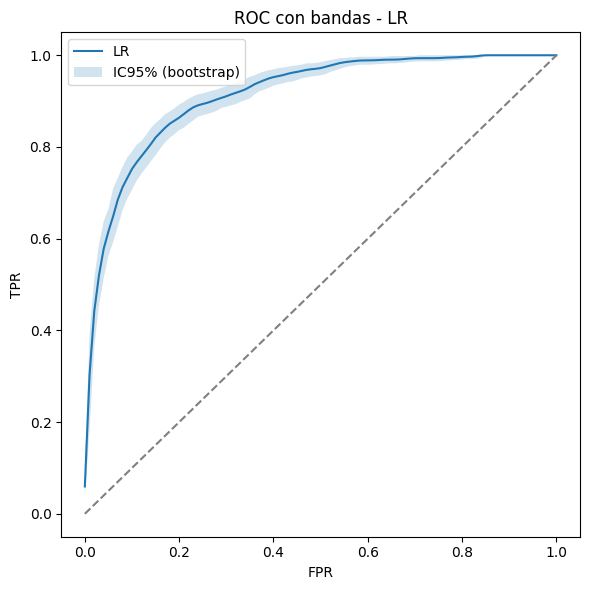

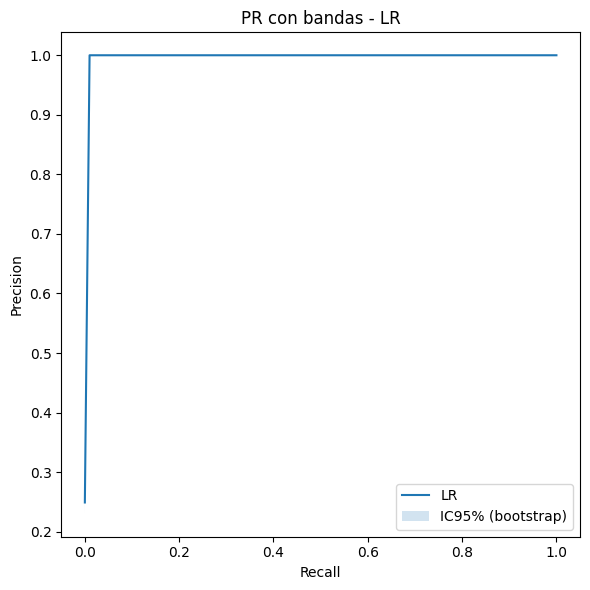

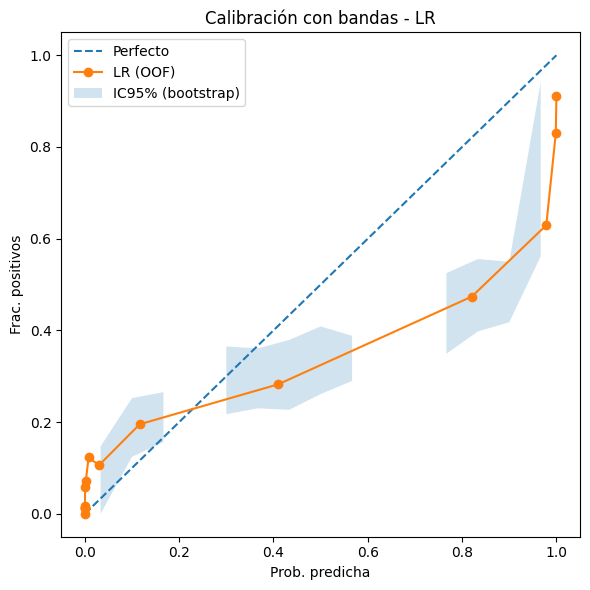

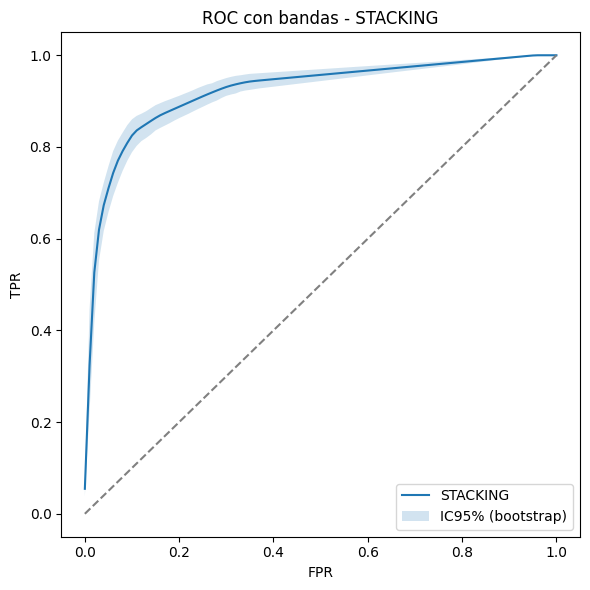

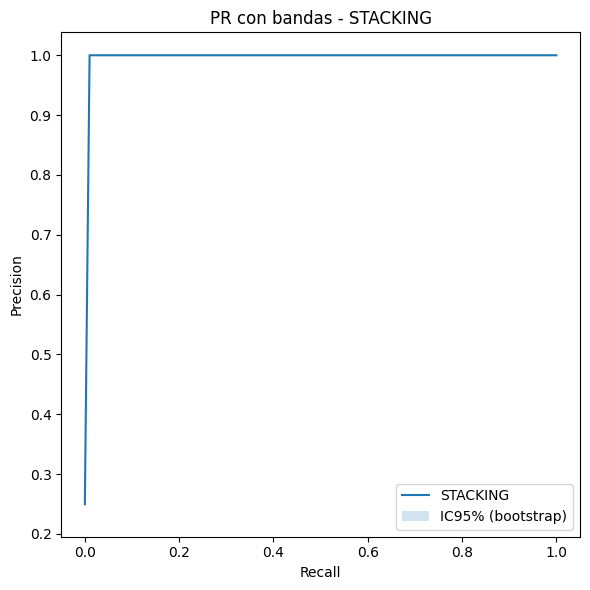

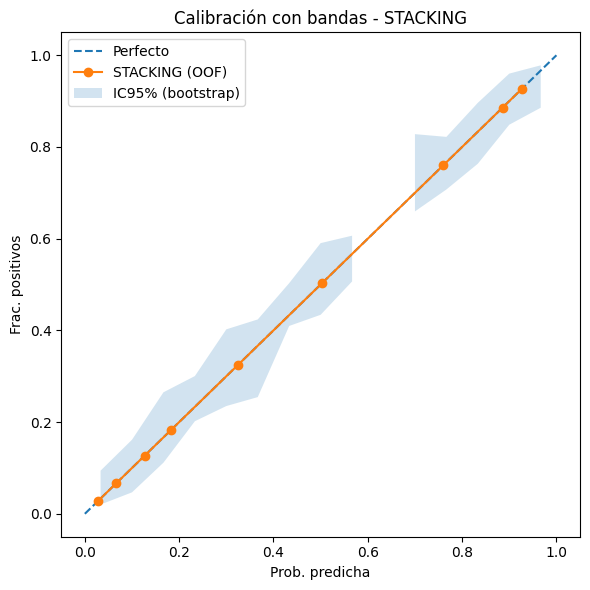

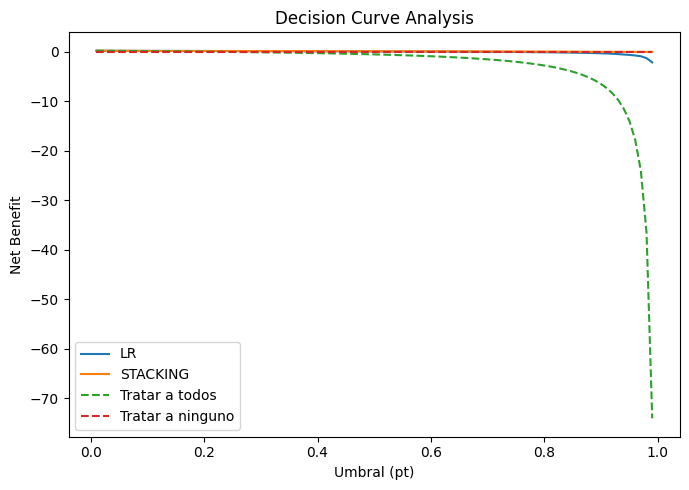

In [6]:
# ============================================================
# FINAL - LR → Zona gris → MLP (gray-boosted) → STACKING (+ ISO)
# Con Brier, ECE, bandas ROC/PR/Calibration y DCA
# Enfatiza mejora dentro de la ZONA GRIS
# ============================================================
import os, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve,
    brier_score_loss, confusion_matrix, precision_score, f1_score, recall_score
)
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks, metrics

# ---------------- Config ----------------
SEED = 42
N_SPLITS = 5
USE_ISOTONIC = True
# zona gris (asimétrica) desde errores de LR
Q_POS, Q_NEG = 0.10, 0.03
# gray-boosting para el MLP
ALPHA = 3.0
BONUS_POS = 1.0
QUADRATIC = True
EPOCHS = 200
BATCH = 64
# bootstrap para bandas
N_BOOT = 400

DATA_PATH = r"C:\Users\axime\Downloads\nueva_data\modelado\MODELO_FINAL\modelo_final.ipynb\df_priority6_with_response_index.csv"
OUT_DIR = os.path.dirname(DATA_PATH)
os.makedirs(OUT_DIR, exist_ok=True)

np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

# ---------------- Carga y prep ----------------
df = pd.read_csv(DATA_PATH)
assert "Response" in df.columns, "Falta columna Response"

X_df = df.drop(columns=[c for c in ["Response","ID"] if c in df.columns])
X_df = pd.get_dummies(X_df, drop_first=False)
y = df["Response"].astype(int).values

imp = SimpleImputer(strategy="median")
scaler = StandardScaler()
X = imp.fit_transform(X_df)
X = scaler.fit_transform(X).astype(np.float32)
INPUT_DIM = X.shape[1]
print(f"[INFO] X shape={X_df.shape}, Pos={y.sum()}, Neg={len(y)-y.sum()} | PosRate={y.mean():.3f}")

def ece_score(y_true, p, n_bins=15):
    bins = np.linspace(0,1,n_bins+1)
    idx = np.digitize(p, bins)-1
    ece = 0.0
    for b in range(n_bins):
        m = (idx==b)
        if m.any():
            ece += m.mean() * abs(y_true[m].mean() - p[m].mean())
    return float(ece)

def best_f1_threshold(y_true, p):
    pr, rc, th = precision_recall_curve(y_true, p)
    f1 = 2*(pr[:-1]*rc[:-1])/(pr[:-1]+rc[:-1]+1e-12)
    return float(th[np.nanargmax(f1)])

# ---------------- 1) LR (OOF) ----------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
oof_lr = np.zeros_like(y, dtype=np.float32)

for fold, (tr, va) in enumerate(skf.split(X,y),1):
    lr = LogisticRegression(solver="liblinear", class_weight="balanced",
                            penalty="l2", C=1.0, max_iter=1000, random_state=SEED+fold)
    lr.fit(X[tr], y[tr])
    oof_lr[va] = lr.predict_proba(X[va])[:,1]

roc_lr = roc_auc_score(y, oof_lr)
pr_lr  = average_precision_score(y, oof_lr)
brier_lr = brier_score_loss(y, oof_lr)
ece_lr   = ece_score(y, oof_lr, n_bins=15)
thr_lr   = best_f1_threshold(y, oof_lr)
print(f"\n=== LR (OOF) ===\nROC-AUC={roc_lr:.4f} | AUCPR={pr_lr:.4f} | Brier={brier_lr:.4f} | ECE={ece_lr:.4f} | BestThr={thr_lr:.4f}")

# ---------------- 2) Zona gris asimétrica (desde errores de LR) ----------------
yhat_lr = (oof_lr >= thr_lr).astype(int)
FP = (yhat_lr==1) & (y==0); FN = (yhat_lr==0) & (y==1)
d_poserr = np.abs(oof_lr[FP] - thr_lr); d_negerr = np.abs(oof_lr[FN] - thr_lr)
if d_poserr.size==0: d_poserr = np.abs(oof_lr[oof_lr>=thr_lr]-thr_lr)
if d_negerr.size==0: d_negerr = np.abs(oof_lr[oof_lr< thr_lr]-thr_lr)
w_pos = float(np.quantile(d_poserr, Q_POS)) if d_poserr.size else 0.0
w_neg = float(np.quantile(d_negerr, Q_NEG)) if d_negerr.size else 0.0
low, high = thr_lr - w_neg, thr_lr + w_pos
mask_gray = (oof_lr >= low) & (oof_lr <= high)

print(f"Zona gris asimétrica: w_neg={w_neg:.4f} | w_pos={w_pos:.4f} -> [{low:.3f}, {high:.3f}]")
print(f"[INFO] % casos en zona gris (OOF): {mask_gray.mean()*100:.2f}%")

# ---------------- 3) MLP (OOF) gray-boosted ----------------
def build_mlp(input_dim, hidden=(256,128,64), dropout=0.30, l2=1e-4, lr=1e-3):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden[0], kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(), layers.Activation("relu"), layers.Dropout(dropout),
        layers.Dense(hidden[1], kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(), layers.Activation("relu"), layers.Dropout(dropout),
        layers.Dense(hidden[2], kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(), layers.Activation("relu"), layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=optimizers.Adam(learning_rate=lr),
              loss="binary_crossentropy",
              metrics=[metrics.AUC(curve="PR", name="auprc"),
                       metrics.AUC(curve="ROC", name="roc_auc")])
    return m

oof_mlp = np.zeros_like(y, dtype=np.float32)

for fold, (tr, va) in enumerate(skf.split(X,y),1):
    X_tr, y_tr = X[tr], y[tr]; X_va, y_va = X[va], y[va]

    # LR fold para pesos de ambigüedad
    lr_fold = LogisticRegression(solver="liblinear", class_weight="balanced",
                                 penalty="l2", C=1.0, max_iter=1000, random_state=SEED+100+fold)
    lr_fold.fit(X_tr, y_tr)
    p_lr_tr = lr_fold.predict_proba(X_tr)[:,1]
    margin = np.abs(p_lr_tr - thr_lr)
    local_w = np.where(p_lr_tr < thr_lr, w_neg, w_pos)
    g = np.zeros_like(margin)
    mask_v = local_w > 0
    base = 1.0 - (margin[mask_v] / (local_w[mask_v] + 1e-6))
    g[mask_v] = np.clip(base, 0.0, 1.0)
    if QUADRATIC: g[mask_v] = g[mask_v]**2
    sw = 1.0 + ALPHA*g
    sw += BONUS_POS * ((g>0) & (y_tr==1))

    mlp = build_mlp(INPUT_DIM)
    _ = mlp.predict(np.zeros((1, INPUT_DIM), dtype=np.float32), batch_size=1, verbose=0)
    cbs = [callbacks.EarlyStopping(monitor="val_auprc", mode="max", patience=20, restore_best_weights=True, verbose=0)]
    mlp.fit(X_tr, y_tr, validation_data=(X_va,y_va), sample_weight=sw,
            epochs=EPOCHS, batch_size=BATCH, callbacks=cbs, verbose=0)
    oof_mlp[va] = mlp.predict(X_va, batch_size=1024, verbose=0).ravel()

print(f"\n=== MLP (OOF gray-boosted) ===\nROC-AUC={roc_auc_score(y,oof_mlp):.4f} | AUCPR={average_precision_score(y,oof_mlp):.4f}")

# ---------------- 4) STACKING (meta-LR + isotónica) ----------------
Z = np.column_stack([
    oof_lr,
    oof_mlp,
    np.abs(oof_lr - thr_lr),
    oof_mlp - oof_lr,
    mask_gray.astype(int)
]).astype(np.float32)

oof_stack = np.zeros_like(y, dtype=np.float32)
for fold, (tr, va) in enumerate(skf.split(Z,y),1):
    meta = LogisticRegression(solver="lbfgs", max_iter=2000, class_weight="balanced", random_state=SEED+200+fold)
    meta.fit(Z[tr], y[tr])
    oof_stack[va] = meta.predict_proba(Z[va])[:,1]

if USE_ISOTONIC:
    iso = IsotonicRegression(out_of_bounds='clip')
    oof_stack = iso.fit_transform(oof_stack, y)

# Global (LR vs STACKING)
roc_s = roc_auc_score(y, oof_stack)
pr_s  = average_precision_score(y, oof_stack)
brier_s = brier_score_loss(y, oof_stack)
ece_s   = ece_score(y, oof_stack, n_bins=15)
thr_s   = best_f1_threshold(y, oof_stack)

# F1 (umbral por F1 en cada modelo)
thr_lr_best = thr_lr
pred_lr = (oof_lr >= thr_lr_best).astype(int)
f1_lr  = f1_score(y, pred_lr); p_lr = precision_score(y, pred_lr, zero_division=0); r_lr = recall_score(y, pred_lr)

pred_s  = (oof_stack >= thr_s).astype(int)
f1_s    = f1_score(y, pred_s); p_s = precision_score(y, pred_s, zero_division=0); r_s = recall_score(y, pred_s)

print(f"\n=== STACKING (OOF {'+ ISO' if USE_ISOTONIC else ''}) ===\nROC-AUC={roc_s:.4f} | AUCPR={pr_s:.4f} | Brier={brier_s:.4f} | ECE={ece_s:.4f}")
print(f"F1={f1_s:.4f} | Prec={p_s:.4f} | Rec={r_s:.4f} (vs LR F1={f1_lr:.4f}, Prec={p_lr:.4f}, Rec={r_lr:.4f})")

# ---------------- 5) Zona gris: métricas (LR vs STACKING) ----------------
def eval_subgroup(y_true, p):
    auprc = average_precision_score(y_true, p)
    pr, rc, th = precision_recall_curve(y_true, p)
    f1s = 2*(pr[:-1]*rc[:-1])/(pr[:-1]+rc[:-1]+1e-12)
    i = np.nanargmax(f1s); thr = th[i]
    pred = (p >= thr).astype(int)
    return dict(AUCPR=auprc, Prec=precision_score(y_true,pred,zero_division=0), F1=f1s[i])

y_g = y[mask_gray]; lr_g = oof_lr[mask_gray]; stk_g = oof_stack[mask_gray]
res_lr_g  = eval_subgroup(y_g, lr_g)
res_st_g  = eval_subgroup(y_g, stk_g)

print("\n=== ZONA GRIS (asimétrica) ===")
print(f"LR       | AUCPR={res_lr_g['AUCPR']:.4f} | Prec={res_lr_g['Prec']:.4f} | F1={res_lr_g['F1']:.4f}")
print(f"STACKING | AUCPR={res_st_g['AUCPR']:.4f} | Prec={res_st_g['Prec']:.4f} | F1={res_st_g['F1']:.4f}")
print(f"Uplift   | ΔAUCPR={res_st_g['AUCPR']-res_lr_g['AUCPR']:+.4f} | ΔPrec={res_st_g['Prec']-res_lr_g['Prec']:+.4f} | ΔF1={res_st_g['F1']-res_lr_g['F1']:+.4f}")

# ---------------- 6) Bandas ROC/PR y Calibración (bootstrap) ----------------
def bootstrap_bands(y_true, p, n_boot=400, seed=SEED):
    rng = np.random.default_rng(seed)
    N = len(y_true)
    fpr_grid = np.linspace(0,1,101)
    rec_grid = np.linspace(0,1,101)
    tprs, precs = [], []
    cal_pts = []
    for _ in range(n_boot):
        idx = rng.integers(0, N, size=N)
        yb, pb = y_true[idx], p[idx]
        fpr, tpr, _ = roc_curve(yb, pb)
        tprs.append(np.interp(fpr_grid, fpr, tpr, left=0, right=1))
        prec, rec, _ = precision_recall_curve(yb, pb)
        rec_u, iu = np.unique(rec, return_index=True)
        prec_u = prec[iu]
        precs.append(np.interp(rec_grid, rec_u[::-1], prec_u[::-1], left=prec_u.min(), right=prec_u.max()))
        pt, pp = calibration_curve(yb, pb, n_bins=15, strategy='quantile')
        cal_pts.append(np.column_stack([pp, pt]))
    tprs = np.array(tprs); precs = np.array(precs)
    return fpr_grid, tprs, rec_grid, precs, np.concatenate(cal_pts, axis=0)

def plot_bands(fpr_grid, tprs, rec_grid, precs, cal_mat, model_name, base_color='C1'):
    # ROC
    plt.figure(figsize=(6,6))
    mean_tpr = tprs.mean(axis=0)
    lo, hi = np.percentile(tprs, [2.5,97.5], axis=0)
    plt.plot(fpr_grid, mean_tpr, label=f'{model_name}')
    plt.fill_between(fpr_grid, lo, hi, alpha=0.2, label='IC95% (bootstrap)')
    plt.plot([0,1],[0,1],'--',color='grey')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC con bandas - {model_name}')
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"roc_band_{model_name}.png"), dpi=150)

    # PR
    plt.figure(figsize=(6,6))
    mean_prec = precs.mean(axis=0)
    lo, hi = np.percentile(precs, [2.5,97.5], axis=0)
    plt.plot(rec_grid, mean_prec, label=f'{model_name}')
    plt.fill_between(rec_grid, lo, hi, alpha=0.2, label='IC95% (bootstrap)')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'PR con bandas - {model_name}')
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"pr_band_{model_name}.png"), dpi=150)

    # Calibration band
    bins = np.linspace(0,1,16)
    idx = np.digitize(cal_mat[:,0], bins)-1
    centers = 0.5*(bins[:-1]+bins[1:])
    ys = [[] for _ in range(15)]
    for i,b in enumerate(idx):
        if 0<=b<15: ys[b].append(cal_mat[i,1])
    y_lo = [np.percentile(v,2.5) if len(v)>5 else np.nan for v in ys]
    y_hi = [np.percentile(v,97.5) if len(v)>5 else np.nan for v in ys]
    y_mu = [np.mean(v) if len(v)>0 else np.nan for v in ys]

    pt, pp = calibration_curve(y, oof_stack if model_name=='STACKING' else oof_lr, n_bins=15, strategy='quantile')
    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1],'--',label='Perfecto')
    plt.plot(pp, pt, marker='o', label=f'{model_name} (OOF)')
    plt.fill_between(centers, y_lo, y_hi, alpha=0.2, label='IC95% (bootstrap)')
    plt.xlabel('Prob. predicha'); plt.ylabel('Frac. positivos'); plt.title(f'Calibración con bandas - {model_name}')
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"reliability_band_{model_name}.png"), dpi=150)

# Bandas para LR
fpr_g, tprs_lr, rec_g, precs_lr, cal_lr = bootstrap_bands(y, oof_lr, n_boot=N_BOOT, seed=SEED)
plot_bands(fpr_g, tprs_lr, rec_g, precs_lr, cal_lr, model_name="LR")

# Bandas para STACKING
fpr_g, tprs_st, rec_g, precs_st, cal_st = bootstrap_bands(y, oof_stack, n_boot=N_BOOT, seed=SEED+1)
plot_bands(fpr_g, tprs_st, rec_g, precs_st, cal_st, model_name="STACKING")

# ---------------- 7) Decision Curve Analysis (DCA) ----------------
def decision_curve(y_true, p, thresholds):
    N = len(y_true); out = []
    for pt in thresholds:
        yhat = (p >= pt).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
        nb = (tp/N) - (fp/N) * (pt/(1-pt))
        out.append(nb)
    return np.array(out)

ths = np.linspace(0.01, 0.99, 99)
nb_lr = decision_curve(y, oof_lr, ths)
nb_st = decision_curve(y, oof_stack, ths)
prev = y.mean()
nb_all  = prev - (1-prev) * (ths/(1-ths))
nb_none = np.zeros_like(ths)

plt.figure(figsize=(7,5))
plt.plot(ths, nb_lr, label='LR')
plt.plot(ths, nb_st, label='STACKING')
plt.plot(ths, nb_all, '--', label='Tratar a todos')
plt.plot(ths, nb_none, '--', label='Tratar a ninguno')
plt.xlabel('Umbral (pt)'); plt.ylabel('Net Benefit'); plt.title('Decision Curve Analysis')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "dca_lr_vs_stacking.png"), dpi=150)

# ---------------- 8) Resumen guardado ----------------
summary = pd.DataFrame({
    "Modelo": ["LR (global)", "STACKING (global)",
               "LR (zona gris)", "STACKING (zona gris)"],
    "AUCPR": [pr_lr, pr_s, res_lr_g["AUCPR"], res_st_g["AUCPR"]],
    "F1":    [f1_lr, f1_s, res_lr_g["F1"],    res_st_g["F1"]],
    "Precision": [p_lr, p_s, res_lr_g["Prec"], res_st_g["Prec"]],
    "Brier": [brier_lr, brier_s, np.nan, np.nan],
    "ECE":   [ece_lr, ece_s, np.nan, np.nan],
    "Z_Gray_%": [mask_gray.mean()*100, mask_gray.mean()*100, mask_gray.mean()*100, mask_gray.mean()*100]
})
sum_csv = os.path.join(OUT_DIR, "final_summary_lr_stacking.csv")
summary.to_csv(sum_csv, index=False)

print("\n[OUTPUTS GUARDADOS]")
print(" - roc_band_LR.png / pr_band_LR.png / reliability_band_LR.png")
print(" - roc_band_STACKING.png / pr_band_STACKING.png / reliability_band_STACKING.png")
print(" - dca_lr_vs_stacking.png")
print(" - final_summary_lr_stacking.csv")


In [2]:
# ============================================================
# FINAL - LR → Zona gris → MLP (gray-boosted) → STACKING (+ ISO)
# Con Brier, ECE, bandas ROC/PR/Calibration y DCA
# ============================================================
import os, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve,
    brier_score_loss, confusion_matrix, precision_score, f1_score, recall_score
)
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks, metrics

# ---------------- Config ----------------
SEED = 42
N_SPLITS = 5
USE_ISOTONIC = True
Q_POS, Q_NEG = 0.10, 0.03
ALPHA = 3.0
BONUS_POS = 1.0
QUADRATIC = True
EPOCHS = 200
BATCH = 64
N_BOOT = 400

DATA_PATH = r"C:\Users\axime\Downloads\nueva_data\modelado\MODELO_FINAL\modelo_final.ipynb\df_priority6_with_response_index.csv"
OUT_DIR = os.path.dirname(DATA_PATH)
os.makedirs(OUT_DIR, exist_ok=True)

np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

# ---------------- Carga y prep ----------------
df = pd.read_csv(DATA_PATH)
assert "Response" in df.columns, "Falta columna Response"

X_df = df.drop(columns=[c for c in ["Response","ID"] if c in df.columns])
X_df = pd.get_dummies(X_df, drop_first=False)
y = df["Response"].astype(int).values

imp = SimpleImputer(strategy="median")
scaler = StandardScaler()
X = imp.fit_transform(X_df)
X = scaler.fit_transform(X).astype(np.float32)
INPUT_DIM = X.shape[1]
print(f"[INFO] X shape={X_df.shape}, Pos={y.sum()}, Neg={len(y)-y.sum()} | PosRate={y.mean():.3f}")

def ece_score(y_true, p, n_bins=15):
    bins = np.linspace(0,1,n_bins+1)
    idx = np.digitize(p, bins)-1
    ece = 0.0
    for b in range(n_bins):
        m = (idx==b)
        if m.any():
            ece += m.mean() * abs(y_true[m].mean() - p[m].mean())
    return float(ece)

def best_f1_threshold(y_true, p):
    pr, rc, th = precision_recall_curve(y_true, p)
    f1 = 2*(pr[:-1]*rc[:-1])/(pr[:-1]+rc[:-1]+1e-12)
    return float(th[np.nanargmax(f1)])

# ---------------- 1) LR (OOF) ----------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
oof_lr = np.zeros_like(y, dtype=np.float32)
lr_folds = []   # NUEVO: contenedor

for fold, (tr, va) in enumerate(skf.split(X,y),1):
    lr = LogisticRegression(solver="liblinear", class_weight="balanced",
                            penalty="l2", C=1.0, max_iter=1000, random_state=SEED+fold)
    lr.fit(X[tr], y[tr])
    oof_lr[va] = lr.predict_proba(X[va])[:,1]
    lr_folds.append(lr)   # NUEVO

roc_lr = roc_auc_score(y, oof_lr)
pr_lr  = average_precision_score(y, oof_lr)
brier_lr = brier_score_loss(y, oof_lr)
ece_lr   = ece_score(y, oof_lr, n_bins=15)
thr_lr   = best_f1_threshold(y, oof_lr)
print(f"\n=== LR (OOF) ===\nROC-AUC={roc_lr:.4f} | AUCPR={pr_lr:.4f} | BestThr={thr_lr:.4f}")

# ---------------- 2) Zona gris asimétrica ----------------
yhat_lr = (oof_lr >= thr_lr).astype(int)
FP = (yhat_lr==1) & (y==0); FN = (yhat_lr==0) & (y==1)
d_poserr = np.abs(oof_lr[FP] - thr_lr); d_negerr = np.abs(oof_lr[FN] - thr_lr)
if d_poserr.size==0: d_poserr = np.abs(oof_lr[oof_lr>=thr_lr]-thr_lr)
if d_negerr.size==0: d_negerr = np.abs(oof_lr[oof_lr< thr_lr]-thr_lr)
w_pos = float(np.quantile(d_poserr, Q_POS)) if d_poserr.size else 0.0
w_neg = float(np.quantile(d_negerr, Q_NEG)) if d_negerr.size else 0.0
low, high = thr_lr - w_neg, thr_lr + w_pos
mask_gray = (oof_lr >= low) & (oof_lr <= high)
print(f"Zona gris asimétrica: w_neg={w_neg:.4f} | w_pos={w_pos:.4f} -> rango: [{low:.3f}, {high:.3f}]")

# ---------------- 3) MLP (OOF gray-boosted) ----------------
def build_mlp(input_dim, hidden=(256,128,64), dropout=0.30, l2=1e-4, lr=1e-3):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden[0], kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(), layers.Activation("relu"), layers.Dropout(dropout),
        layers.Dense(hidden[1], kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(), layers.Activation("relu"), layers.Dropout(dropout),
        layers.Dense(hidden[2], kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(), layers.Activation("relu"), layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="binary_crossentropy")
    return m

oof_mlp = np.zeros_like(y, dtype=np.float32)
mlp_folds = []   # NUEVO

for fold, (tr, va) in enumerate(skf.split(X,y),1):
    X_tr, y_tr = X[tr], y[tr]; X_va, y_va = X[va], y[va]

    lr_fold = LogisticRegression(solver="liblinear", class_weight="balanced",
                                 penalty="l2", C=1.0, max_iter=1000, random_state=SEED+100+fold)
    lr_fold.fit(X_tr, y_tr)
    p_lr_tr = lr_fold.predict_proba(X_tr)[:,1]
    margin = np.abs(p_lr_tr - thr_lr)
    local_w = np.where(p_lr_tr < thr_lr, w_neg, w_pos)
    g = np.zeros_like(margin)
    mask_v = local_w > 0
    base = 1.0 - (margin[mask_v] / (local_w[mask_v] + 1e-6))
    g[mask_v] = np.clip(base, 0.0, 1.0)
    if QUADRATIC: g[mask_v] = g[mask_v]**2
    sw = 1.0 + ALPHA*g
    sw += BONUS_POS * ((g>0) & (y_tr==1))

    mlp = build_mlp(INPUT_DIM)
    _ = mlp.predict(np.zeros((1, INPUT_DIM), dtype=np.float32), batch_size=1, verbose=0)
    cbs = [callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=0)]
    mlp.fit(X_tr, y_tr, validation_data=(X_va,y_va), sample_weight=sw,
            epochs=EPOCHS, batch_size=BATCH, callbacks=cbs, verbose=0)
    oof_mlp[va] = mlp.predict(X_va, batch_size=1024, verbose=0).ravel()
    mlp_folds.append(mlp)   # NUEVO

print(f"\n=== MLP (OOF gray-boosted) ===\nROC-AUC={roc_auc_score(y,oof_mlp):.4f} | AUCPR={average_precision_score(y,oof_mlp):.4f}")

# ---------------- 4) STACKING (meta-LR + isotónica) ----------------
Z = np.column_stack([oof_lr, oof_mlp, np.abs(oof_lr - thr_lr), oof_mlp - oof_lr, mask_gray.astype(int)]).astype(np.float32)
oof_stack = np.zeros_like(y, dtype=np.float32)
meta_folds = []   # NUEVO

for fold, (tr, va) in enumerate(skf.split(Z,y),1):
    meta = LogisticRegression(solver="lbfgs", max_iter=2000, class_weight="balanced", random_state=SEED+200+fold)
    meta.fit(Z[tr], y[tr])
    oof_stack[va] = meta.predict_proba(Z[va])[:,1]
    meta_folds.append(meta)   # NUEVO

if USE_ISOTONIC:
    iso = IsotonicRegression(out_of_bounds='clip')
    oof_stack = iso.fit_transform(oof_stack, y)

print(f"\n=== STACKING (OOF {'+ ISO' if USE_ISOTONIC else ''}) ===\nROC-AUC={roc_auc_score(y,oof_stack):.4f} | AUCPR={average_precision_score(y,oof_stack):.4f}")


[INFO] X shape=(2551, 730), Pos=635, Neg=1916 | PosRate=0.249

=== LR (OOF) ===
ROC-AUC=0.9139 | AUCPR=0.7982 | BestThr=0.6292
Zona gris asimétrica: w_neg=0.0761 | w_pos=0.0975 -> rango: [0.553, 0.727]

=== MLP (OOF gray-boosted) ===
ROC-AUC=0.9218 | AUCPR=0.8219

=== STACKING (OOF + ISO) ===
ROC-AUC=0.9226 | AUCPR=0.8144


In [3]:
# ================== SERIALIZACIÓN ==================
import os, json, joblib
from dataclasses import dataclass
from typing import List
import tensorflow as tf

ART_DIR = OUT_DIR
os.makedirs(ART_DIR, exist_ok=True)

# Guardar MLPs de cada fold
mlp_paths = []
for k, mlp in enumerate(mlp_folds, start=1):
    pth = os.path.join(ART_DIR, f"mlp_fold{k}.keras")
    mlp.save(pth)
    mlp_paths.append(pth)

# Guardar columnas de entrenamiento
columns = list(X_df.columns)
with open(os.path.join(ART_DIR, "columns.json"), "w", encoding="utf-8") as f:
    json.dump(columns, f, ensure_ascii=False, indent=2)

# Contenedor final
@dataclass
class CVGrayStackingPredictor:
    imputor: SimpleImputer
    scaler: StandardScaler
    train_columns: List[str]
    lr_folds: List[object]
    meta_folds: List[object]
    mlp_paths: List[str]
    iso: IsotonicRegression
    thr_lr: float
    w_neg: float
    w_pos: float
    low: float
    high: float

    def _prep(self, X_new_raw: pd.DataFrame) -> np.ndarray:
        X_new = pd.get_dummies(X_new_raw, drop_first=False)
        missing = [c for c in self.train_columns if c not in X_new.columns]
        for c in missing: X_new[c] = 0
        extra = [c for c in X_new.columns if c not in self.train_columns]
        if extra: X_new = X_new.drop(columns=extra)
        X_new = X_new[self.train_columns]
        X_new = self.imputor.transform(X_new)
        X_new = self.scaler.transform(X_new).astype(np.float32)
        return X_new

    def predict_proba(self, X_new_raw: pd.DataFrame) -> np.ndarray:
        Xp = self._prep(X_new_raw)
        ps = []
        for lr, meta, mlp_path in zip(self.lr_folds, self.meta_folds, self.mlp_paths):
            mlp = tf.keras.models.load_model(mlp_path)
            p_lr = lr.predict_proba(Xp)[:,1]
            p_mlp = mlp.predict(Xp, batch_size=1024, verbose=0).ravel()
            Z = np.column_stack([
                p_lr, p_mlp,
                np.abs(p_lr - self.thr_lr),
                p_mlp - p_lr,
                ((p_lr >= self.low) & (p_lr <= self.high)).astype(int)
            ]).astype(np.float32)
            ps.append(meta.predict_proba(Z)[:,1])
        p_raw = np.mean(np.column_stack(ps), axis=1)
        return self.iso.transform(p_raw)

    def predict(self, X_new_raw: pd.DataFrame, threshold: float = None) -> np.ndarray:
        p = self.predict_proba(X_new_raw)
        thr = float(threshold) if threshold is not None else self.thr_lr
        return (p >= thr).astype(int)

# Instanciar y guardar
predictor = CVGrayStackingPredictor(
    imputor = imp,
    scaler = scaler,
    train_columns = columns,
    lr_folds = lr_folds,
    meta_folds = meta_folds,
    mlp_paths = mlp_paths,
    iso = iso,
    thr_lr = float(thr_lr),
    w_neg = float(w_neg),
    w_pos = float(w_pos),
    low = float(low),
    high = float(high),
)
joblib.dump(predictor, os.path.join(ART_DIR, "predictor_cv.pkl"))

print("\n[OK] Artefactos guardados:")
print(" - predictor_cv.pkl")
print(" - columns.json")
for p in mlp_paths: print(" -", os.path.basename(p))



[OK] Artefactos guardados:
 - predictor_cv.pkl
 - columns.json
 - mlp_fold1.keras
 - mlp_fold2.keras
 - mlp_fold3.keras
 - mlp_fold4.keras
 - mlp_fold5.keras


In [5]:
import os, joblib, pandas as pd

ART_DIR = r"C:\Users\axime\Downloads\nueva_data\modelado\MODELO_FINAL\modelo_final.ipynb"
predictor = joblib.load(os.path.join(ART_DIR, "predictor_cv.pkl"))

NEW_PATH = r"C:\Users\axime\Downloads\MODELO_FINAL\MODELO_FINAL\modelo_final.ipynb\data_GSE25065_filtered.csv"
new_df = pd.read_csv(NEW_PATH)

probas = predictor.predict_proba(new_df)
preds  = predictor.predict(new_df)

out = new_df.copy()
out["proba_stacking_iso"] = probas
out["pred"] = preds
out.to_csv(os.path.join(ART_DIR, "predicciones_nuevo.csv"), index=False)
print("[OK] predicciones_nuevo.csv")



[OK] predicciones_nuevo.csv


In [6]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, f1_score, precision_score, recall_score,
    brier_score_loss, confusion_matrix
)

# y_true
if "Response" not in new_df.columns:
    raise ValueError("El dataset no tiene la columna 'Response' para evaluar métricas.")

y_true = new_df["Response"].astype(int).values

# Probabilidades y predicciones
y_prob = probas
y_pred = preds

# ====== MÉTRICAS ======
roc_auc = roc_auc_score(y_true, y_prob)
auprc   = average_precision_score(y_true, y_prob)
acc     = accuracy_score(y_true, y_pred)
f1      = f1_score(y_true, y_pred)
prec    = precision_score(y_true, y_pred, zero_division=0)
rec     = recall_score(y_true, y_pred)
brier   = brier_score_loss(y_true, y_prob)

cm = confusion_matrix(y_true, y_pred)

print("\n=== Métricas en data nueva ===")
print(f"ROC-AUC : {roc_auc:.4f}")
print(f"AUCPR   : {auprc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1      : {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall  : {rec:.4f}")
print(f"Brier   : {brier:.4f}")
print("\nMatriz de confusión:")
print(cm)



=== Métricas en data nueva ===
ROC-AUC : 0.9361
AUCPR   : 0.7773
Accuracy: 0.7879
F1      : 0.0000
Precision: 0.0000
Recall  : 0.0000
Brier   : 0.1533

Matriz de confusión:
[[156   0]
 [ 42   0]]


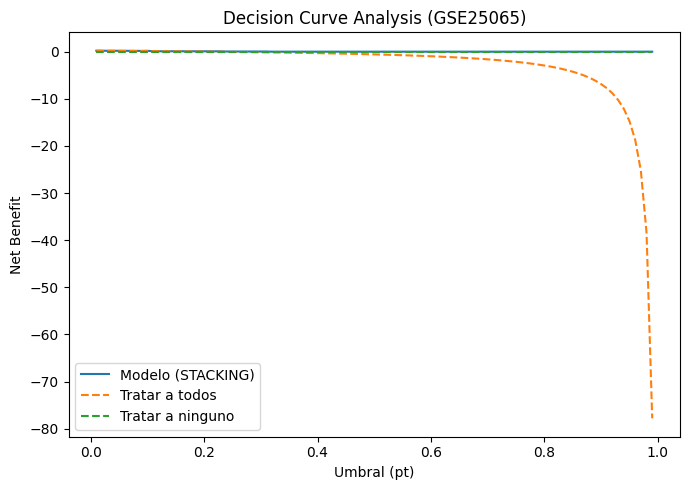

[INFO] Umbral con mayor Net Benefit: pt* = 0.010


In [8]:
import os, numpy as np, pandas as pd, joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- Cargar artefactos y data ---
ART_DIR = r"C:\Users\axime\Downloads\nueva_data\modelado\MODELO_FINAL\modelo_final.ipynb"  # carpeta donde guardaste predictor_cv.pkl
PRED_PATH = os.path.join(ART_DIR, "predictor_cv.pkl")
CSV_PATH  = r"C:\Users\axime\Downloads\MODELO_FINAL\MODELO_FINAL\modelo_final.ipynb\data_GSE25065_filtered.csv"

predictor = joblib.load(PRED_PATH)
df = pd.read_csv(CSV_PATH)
assert "Response" in df.columns, "Necesitas la columna 'Response' para calcular DCA."

y_true = df["Response"].astype(int).values
p_hat  = predictor.predict_proba(df)  # probas calibradas del STACKING

# --- Net Benefit ---
def decision_curve(y_true, p, thresholds):
    N = len(y_true)
    out = []
    for pt in thresholds:
        yhat = (p >= pt).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
        nb = (tp/N) - (fp/N) * (pt/(1-pt))
        out.append(nb)
    return np.array(out)

ths = np.linspace(0.01, 0.99, 99)
nb_model = decision_curve(y_true, p_hat, ths)
prev = y_true.mean()
nb_all  = prev - (1-prev) * (ths/(1-ths))   # tratar a todos
nb_none = np.zeros_like(ths)                 # tratar a ninguno

# --- Plot ---
plt.figure(figsize=(7,5))
plt.plot(ths, nb_model, label='Modelo (STACKING)')
plt.plot(ths, nb_all, '--', label='Tratar a todos')
plt.plot(ths, nb_none, '--', label='Tratar a ninguno')
plt.xlabel('Umbral (pt)'); plt.ylabel('Net Benefit'); plt.title('Decision Curve Analysis (GSE25065)')
plt.legend(); plt.tight_layout()
plt.show()

# Umbral recomendado (máx NB del modelo)
pt_star = ths[np.argmax(nb_model)]
print(f"[INFO] Umbral con mayor Net Benefit: pt* = {pt_star:.3f}")


In [11]:
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, f1_score, precision_score, recall_score,
    brier_score_loss, precision_recall_curve, confusion_matrix
)

df_ext = new_df.copy()
y = df_ext["Response"].astype(int).values
p = predictor.predict_proba(df_ext).astype(float)

def metrics(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    return dict(
        Threshold=float(thr),
        ROC_AUC=roc_auc_score(y_true, y_prob),
        AUCPR=average_precision_score(y_true, y_prob),
        Accuracy=accuracy_score(y_true, y_hat),
        F1=f1_score(y_true, y_hat),
        Precision=precision_score(y_true, y_hat, zero_division=0),
        Recall=recall_score(y_true, y_hat),
        Brier=brier_score_loss(y_true, y_prob),
        TN=int(tn), FP=int(fp), FN=int(fn), TP=int(tp)
    )

# --- 1) Evaluación con UMBRAL ORIGINAL del modelo ---
thr_orig = float(predictor.thr_lr)
m_orig = metrics(y, p, thr_orig)

# --- 2) Calib&Test split (recalibrar SOLO en calib) ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
(calib_idx, test_idx), = sss.split(np.zeros_like(y), y)

y_cal, p_cal = y[calib_idx], p[calib_idx]
y_te , p_te  = y[test_idx],  p[test_idx]

# 2a) Recalibración isotónica en el calib set
iso_ext = IsotonicRegression(out_of_bounds='clip')
p_cal_iso = iso_ext.fit_transform(p_cal, y_cal)
p_te_iso  = iso_ext.transform(p_te)

# 2b) Elegir umbral en calib por F1 y aplicarlo al test
pr, rc, th = precision_recall_curve(y_cal, p_cal_iso)
f1s = 2*(pr[:-1]*rc[:-1])/(pr[:-1]+rc[:-1]+1e-12)
thr_best = float(th[np.nanargmax(f1s)])

m_cal = metrics(y_cal, p_cal_iso, thr_best)   # para tu reporte (calib)
m_te  = metrics(y_te , p_te_iso , thr_best)   # MÉTRICAS PRINCIPALES (test)

# --- 3) Imprimir resumen
def pretty(tag, m):
    print(f"\n[{tag}]")
    for k,v in m.items():
        if k in ("TN","FP","FN","TP"): continue
        print(f"{k:10s}: {v:.4f}" if isinstance(v,float) else f"{k:10s}: {v}")
    print(f"CM         : [[{m['TN']} {m['FP']}], [{m['FN']} {m['TP']}] ]")

print("\n=== ESCENARIO A: UMBRAL ORIGINAL (cohorte externa completa) ===")
pretty("Original", m_orig)

print("\n=== ESCENARIO B: CALIB&TEST (recalibrado en calib, evaluado en test) ===")
pretty("Calib (para elegir umbral)", m_cal)
pretty("Test  (métricas reportables)", m_te)

# --- 4) (opcional) Guardar resumen
summary = pd.DataFrame([{"Escenario":"Original", **m_orig},
                        {"Escenario":"Calib",   **m_cal},
                        {"Escenario":"Test",    **m_te}])
summary_path = os.path.join(ART_DIR, "externo_GSE25065_recalibracion_y_umbral.csv")
summary.to_csv(summary_path, index=False)
print(f"\n[OK] Resumen guardado en: {summary_path}")



=== ESCENARIO A: UMBRAL ORIGINAL (cohorte externa completa) ===

[Original]
Threshold : 0.6292
ROC_AUC   : 0.9361
AUCPR     : 0.7773
Accuracy  : 0.7879
F1        : 0.0000
Precision : 0.0000
Recall    : 0.0000
Brier     : 0.1533
CM         : [[156 0], [42 0] ]

=== ESCENARIO B: CALIB&TEST (recalibrado en calib, evaluado en test) ===

[Calib (para elegir umbral)]
Threshold : 0.6111
ROC_AUC   : 0.9423
AUCPR     : 0.7923
Accuracy  : 0.9091
F1        : 0.8085
Precision : 0.7308
Recall    : 0.9048
Brier     : 0.0625
CM         : [[71 7], [2 19] ]

[Test  (métricas reportables)]
Threshold : 0.6111
ROC_AUC   : 0.9377
AUCPR     : 0.7605
Accuracy  : 0.8586
F1        : 0.7407
Precision : 0.6061
Recall    : 0.9524
Brier     : 0.0758
CM         : [[65 13], [1 20] ]

[OK] Resumen guardado en: C:\Users\axime\Downloads\nueva_data\modelado\MODELO_FINAL\modelo_final.ipynb\externo_GSE25065_recalibracion_y_umbral.csv
